# Token Malice Prediction Results Analysis

In [2]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# Set style
plt.style.use('default')
sns.set_palette('husl')

In [3]:
# Run the training (uncomment if needed)
# !python -m token_malice_predictor config.yaml

In [4]:
# Load results from JSONL
results_path = Path('./outputs/results.jsonl')
results = []

with open(results_path, 'r') as f:
    for line in f:
        results.append(json.loads(line))

print(f"Loaded {len(results)} experiment results")
print("Runs:", [r['run_name'] for r in results])

Loaded 3 experiment results
Runs: ['hidden_32', 'hidden_64', 'hidden_128']


In [6]:
# Import compute_metrics function
from token_malice_predictor.metrics import compute_metrics

# Compute detailed metrics for each run
for result in results:
    metrics = compute_metrics(
        y_true=result['labels'],
        y_pred=result['predictions'],
        y_prob=result['probabilities']
    )
    result['detailed_metrics'] = metrics

print("Computed detailed metrics for all runs")

Computed detailed metrics for all runs


# Results

In [7]:
# Create summary DataFrame
summary_data = []
for result in results:
    row = {
        'Run': result['run_name'],
        'Hidden Dim': result['hidden_dim'],
        'Test Loss': result['test_loss'],
        'Test Accuracy': result['test_accuracy'],
        'Precision': result['detailed_metrics']['precision'],
        'Recall': result['detailed_metrics']['recall'],
        'F1 Score': result['detailed_metrics']['f1'],
        'AUROC': result['detailed_metrics'].get('auroc', 'N/A'),
        'AUPRC': result['detailed_metrics'].get('auprc', 'N/A'),
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df

,Run,Hidden Dim,Test Loss,Test Accuracy,Precision,Recall,F1 Score,AUROC,AUPRC
0,hidden_32,32,2.175533,0.959849,0.0,0.0,0.0,0.549939,0.049734
1,hidden_64,64,2.180665,0.959849,0.0,0.0,0.0,0.613011,0.058214
2,hidden_128,128,1.958103,0.959849,0.0,0.0,0.0,0.591605,0.052621


## Epoch History Analysis

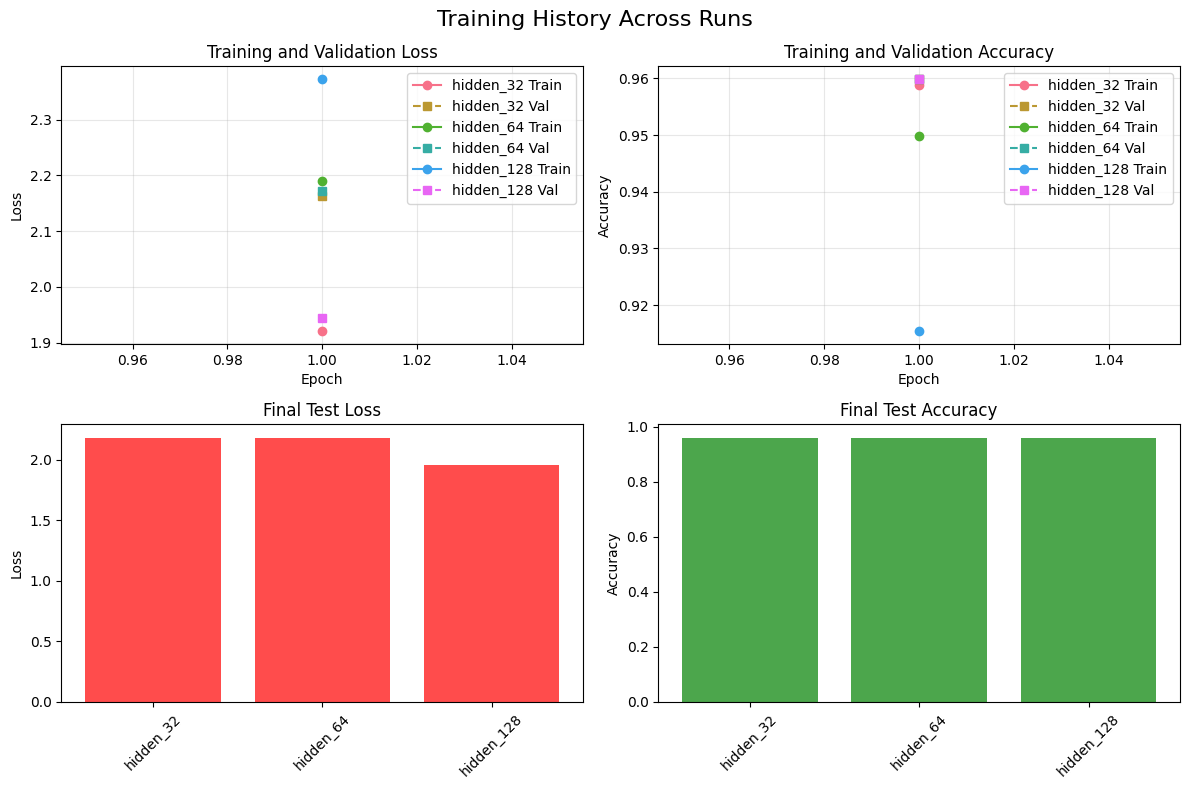

In [20]:
# Plot epoch history (train and val loss/accuracy)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Training History Across Runs', fontsize=16)

for result in results:
    run_name = result['run_name']
    history = result['epoch_history']
    
    epochs = [h['epoch'] for h in history['train']]
    
    # Train loss
    train_loss = [h['loss'] for h in history['train']]
    axes[0,0].plot(epochs, train_loss, marker='o', label=f'{run_name} Train')
    
    # Val loss
    val_loss = [h['loss'] for h in history['val']]
    axes[0,0].plot(epochs, val_loss, marker='s', linestyle='--', label=f'{run_name} Val')
    
    # Train accuracy
    train_acc = [h['accuracy'] for h in history['train']]
    axes[0,1].plot(epochs, train_acc, marker='o', label=f'{run_name} Train')
    
    # Val accuracy
    val_acc = [h['accuracy'] for h in history['val']]
    axes[0,1].plot(epochs, val_acc, marker='s', linestyle='--', label=f'{run_name} Val')

axes[0,0].set_title('Training and Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Since only 1 epoch, add final test metrics
test_acc = [r['test_accuracy'] for r in results]
test_loss = [r['test_loss'] for r in results]
runs = [r['run_name'] for r in results]

axes[1,0].bar(runs, test_loss, color='red', alpha=0.7)
axes[1,0].set_title('Final Test Loss')
axes[1,0].set_ylabel('Loss')
axes[1,0].tick_params(axis='x', rotation=45)

axes[1,1].bar(runs, test_acc, color='green', alpha=0.7)
axes[1,1].set_title('Final Test Accuracy')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Metrics Analysis

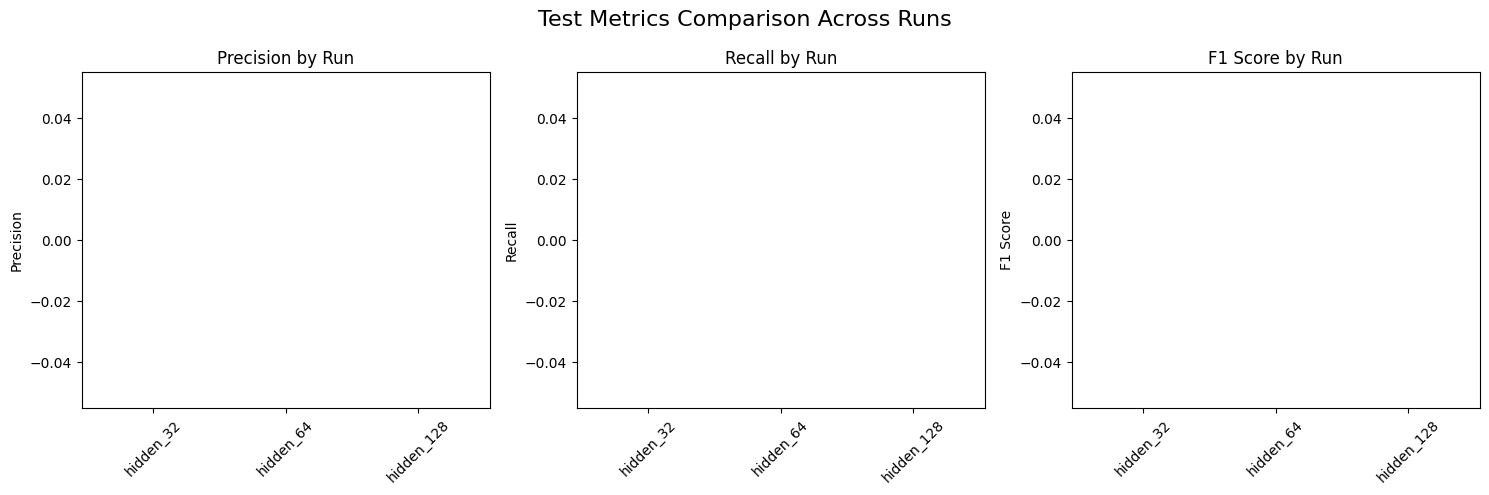

In [22]:
# Plot test metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Test Metrics Comparison Across Runs', fontsize=16)

metrics = ['Precision', 'Recall', 'F1 Score', ]
colors = ['green', 'purple', 'orange']

for i, metric in enumerate(metrics):
    ax = axes[i%3]
    values = summary_df[metric]
    if metric == 'Test Loss':
        values = -values  # For bar plot, make loss negative for better visualization
        ax.bar(summary_df['Run'], values, color=colors[i], alpha=0.7)
        ax.set_ylabel(f'Negative {metric}')
    else:
        ax.bar(summary_df['Run'], values, color=colors[i], alpha=0.7)
        ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Run')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Confusion Matrices

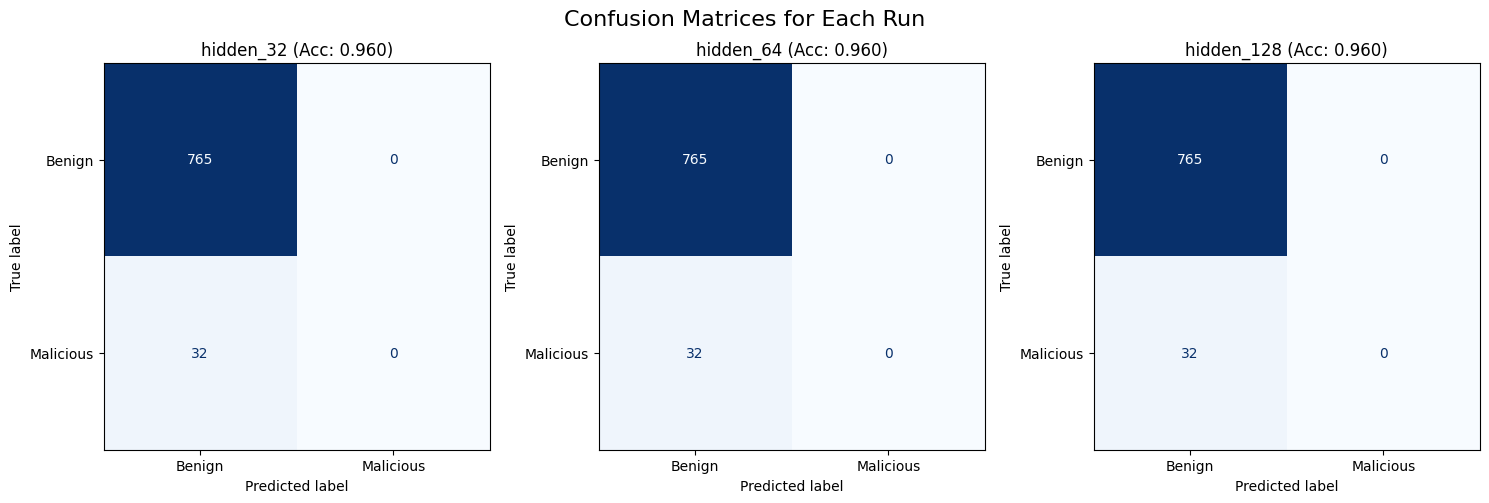

In [23]:
# Plot confusion matrices for each run
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices for Each Run', fontsize=16)

for i, result in enumerate(results):
    cm = confusion_matrix(result['labels'], result['predictions'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malicious'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'{result["run_name"]} (Acc: {result["test_accuracy"]:.3f})')

plt.tight_layout()
plt.show()

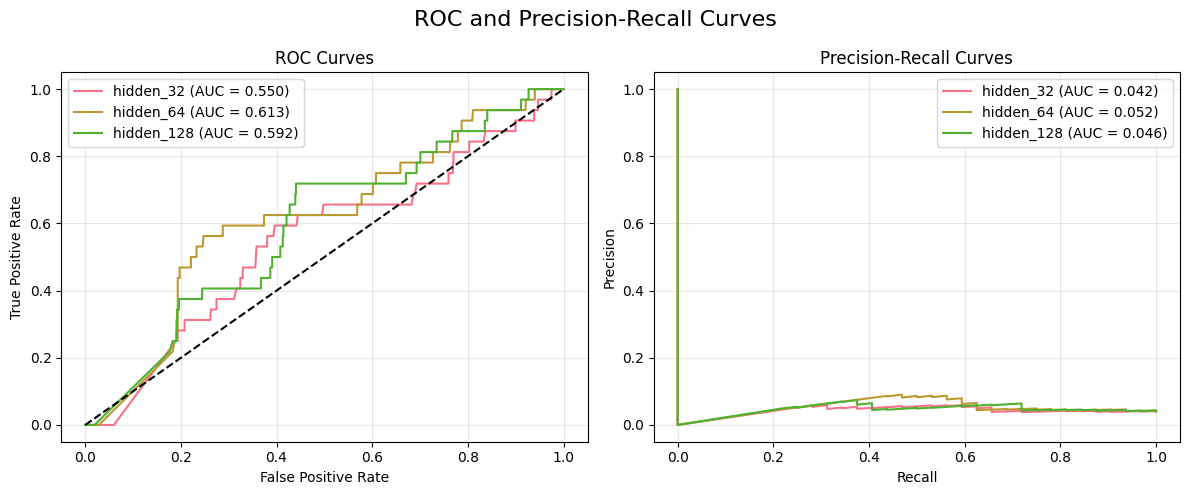

In [24]:
# Plot ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('ROC and Precision-Recall Curves', fontsize=16)

for result in results:
    run_name = result['run_name']
    labels = np.array(result['labels'])
    probs = np.array(result['probabilities'])
    
    # ROC
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{run_name} (AUC = {roc_auc:.3f})')
    
    # PR
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, label=f'{run_name} (AUC = {pr_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

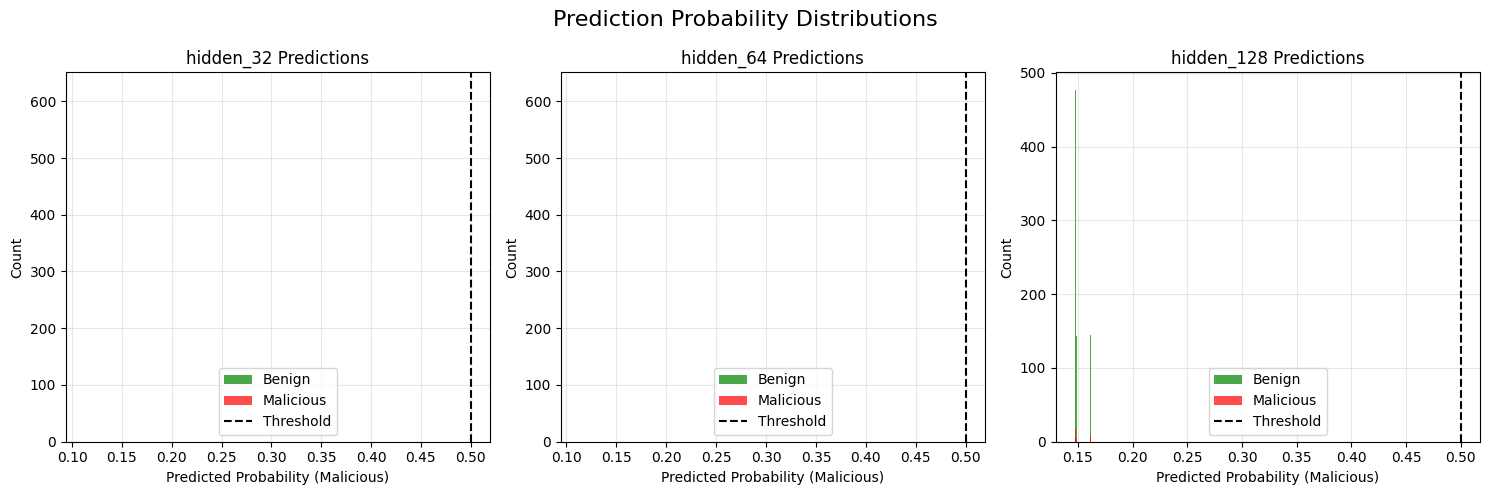

In [25]:
# Analyze prediction probability distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Prediction Probability Distributions', fontsize=16)

for i, result in enumerate(results):
    probs = np.array(result['probabilities'])
    labels = np.array(result['labels'])
    
    axes[i].hist(probs[labels == 0], bins=20, alpha=0.7, label='Benign', color='green')
    axes[i].hist(probs[labels == 1], bins=20, alpha=0.7, label='Malicious', color='red')
    axes[i].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    axes[i].set_xlabel('Predicted Probability (Malicious)')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'{result["run_name"]} Predictions')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [26]:
# Print summary of results
print("=== EXPERIMENT SUMMARY ===")
print(f"Total runs: {len(results)}")
print()

for result in results:
    print(f"Run: {result['run_name']}")
    print(f"  Hidden Dim: {result['hidden_dim']}")
    print(f"  Test Loss: {result['test_loss']:.4f}")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"  Precision: {result['detailed_metrics']['precision']:.4f}")
    print(f"  Recall: {result['detailed_metrics']['recall']:.4f}")
    print(f"  F1 Score: {result['detailed_metrics']['f1']:.4f}")
    if 'auroc' in result['detailed_metrics']:
        print(f"  AUROC: {result['detailed_metrics']['auroc']:.4f}")
    if 'auprc' in result['detailed_metrics']:
        print(f"  AUPRC: {result['detailed_metrics']['auprc']:.4f}")
    print()

# Find best run
best_run = max(results, key=lambda x: x['test_accuracy'])
print(f"Best performing run: {best_run['run_name']} (Test Acc: {best_run['test_accuracy']:.4f})")

=== EXPERIMENT SUMMARY ===
Total runs: 3

Run: hidden_32
  Hidden Dim: 32
  Test Loss: 2.1755
  Test Accuracy: 0.9598
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUROC: 0.5499
  AUPRC: 0.0497

Run: hidden_64
  Hidden Dim: 64
  Test Loss: 2.1807
  Test Accuracy: 0.9598
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUROC: 0.6130
  AUPRC: 0.0582

Run: hidden_128
  Hidden Dim: 128
  Test Loss: 1.9581
  Test Accuracy: 0.9598
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  AUROC: 0.5916
  AUPRC: 0.0526

Best performing run: hidden_32 (Test Acc: 0.9598)
